**Fake Face Generator using DCGAN**


In [ ]:
# !pip install opendatasets --upgrade


In [1]:
import opendatasets as od

In [1]:
import os
DATA_DIR = './celeb_dataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [3]:
image_size = 64
batch_size = 128 
# means of 0.5 and standard deviation 0.5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),e 
    T.ToTensor(), 
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=3, 
                      pin_memory=True)

lets create helper function to denormalize the image tensors the image tensors and display some sampel image from a training batch 

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

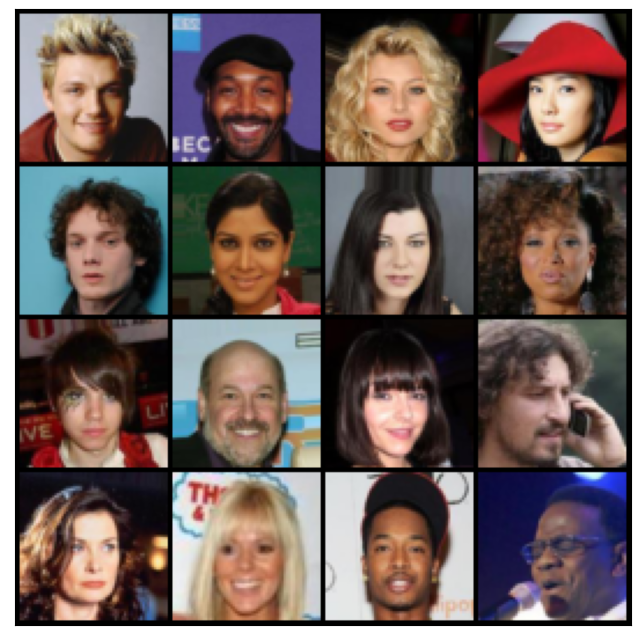

In [8]:
show_batch(train_dl)

#### GPU Selection

In [9]:
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# it will load data to device 
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
     
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
     
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
 train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # activation function
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


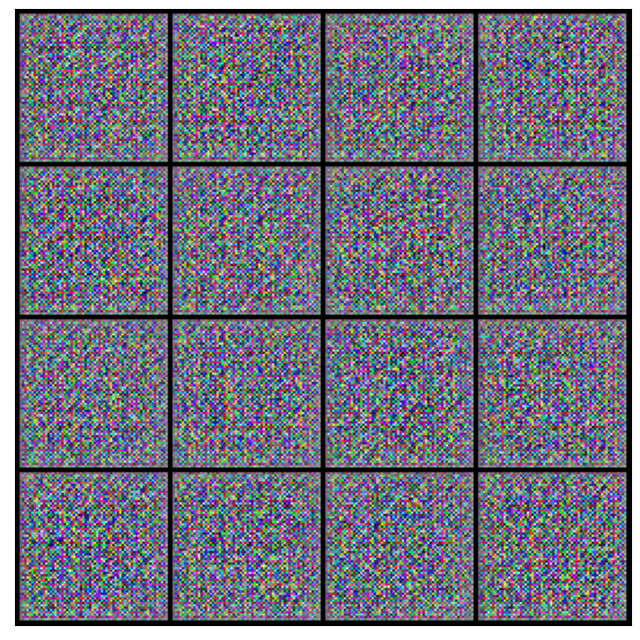

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    # after backword descriminator will able to predict more accurate images
    opt_d.step() #it will update weights 
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

after every epoch we will store imges which is generated by out generator 

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


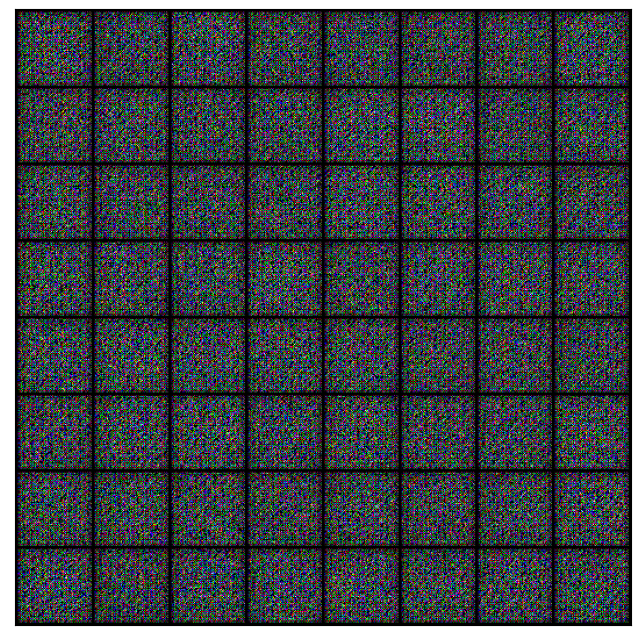

In [25]:
save_samples(0, fixed_latent)

In [26]:
# progress bar 
from tqdm.notebook import tqdm 
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 10

In [29]:
history = fit(epochs, lr)

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 3.1896, loss_d: 0.5389, real_score: 0.7747, fake_score: 0.1992
Saving generated-images-0001.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 1.1312, loss_d: 1.3980, real_score: 0.3113, fake_score: 0.0063
Saving generated-images-0002.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 3.3842, loss_d: 0.2736, real_score: 0.8064, fake_score: 0.0322
Saving generated-images-0003.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.9287, loss_d: 0.3600, real_score: 0.9253, fake_score: 0.2249
Saving generated-images-0004.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.5573, loss_d: 0.3151, real_score: 0.9862, fake_score: 0.2281
Saving generated-images-0005.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.3602, loss_d: 0.1690, real_score: 0.9392, fake_score: 0.0928
Saving generated-images-0006.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.5004, loss_d: 0.2359, real_score: 0.9656, fake_score: 0.1634
Saving generated-images-0007.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.3084, loss_d: 0.4102, real_score: 0.9689, fake_score: 0.2543
Saving generated-images-0008.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.0682, loss_d: 0.5097, real_score: 0.9566, fake_score: 0.3212
Saving generated-images-0009.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 8.4741, loss_d: 4.3532, real_score: 0.9987, fake_score: 0.9479
Saving generated-images-0010.png


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
# Saving the model checkpoints 
torch.save(generator.state_dict(), 'face_Gen.pth')
torch.save(discriminator.state_dict(), 'face_Dis.pth')

In [32]:
from IPython.display import Image

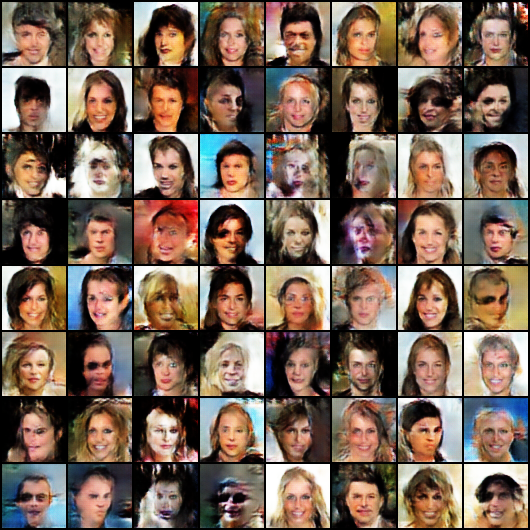

In [34]:
Image('./generated/generated-images-0002.png')

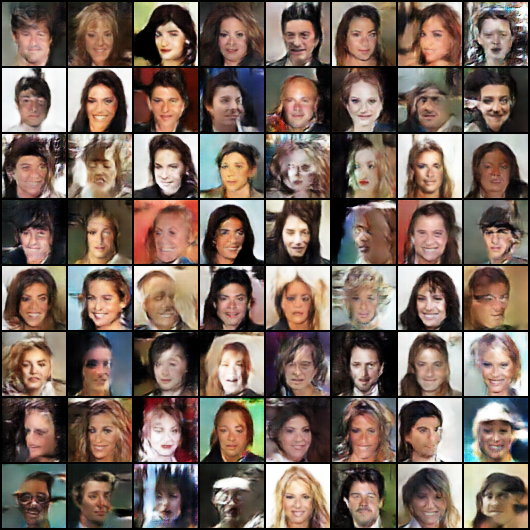

In [36]:
Image('./generated/generated-images-0004.png')

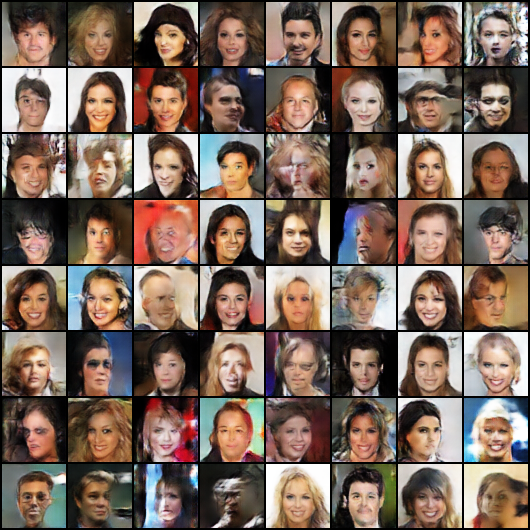

In [37]:
Image('./generated/generated-images-0005.png')

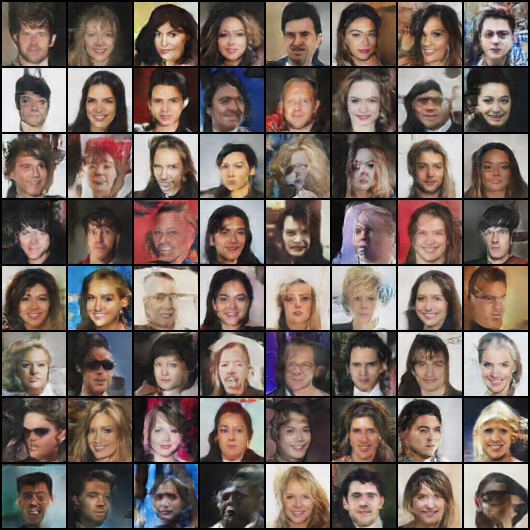

In [38]:
Image('./generated/generated-images-0010.png')


In [39]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

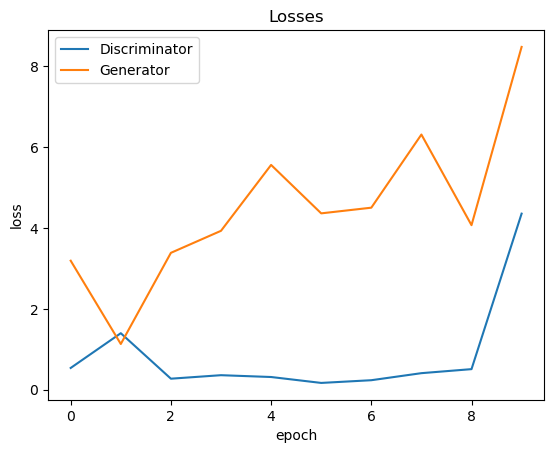

In [40]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

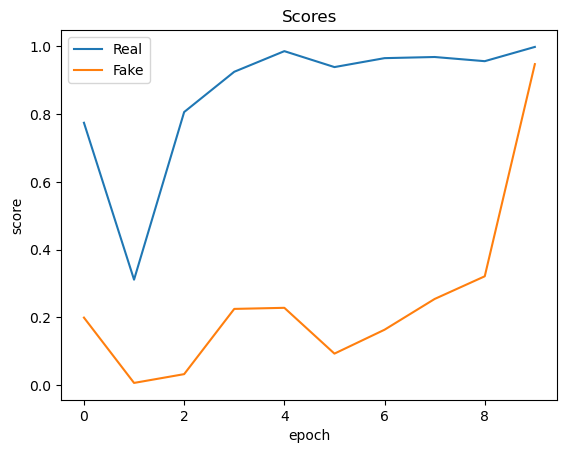

In [41]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [43]:
h2 = fit(40, lr)

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 4.6885, loss_d: 0.1053, real_score: 0.9349, fake_score: 0.0331
Saving generated-images-0001.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 4.4091, loss_d: 0.0790, real_score: 0.9724, fake_score: 0.0472
Saving generated-images-0002.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 4.6988, loss_d: 0.1111, real_score: 0.9763, fake_score: 0.0754
Saving generated-images-0003.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 3.4455, loss_d: 0.1372, real_score: 0.9277, fake_score: 0.0533
Saving generated-images-0004.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 2.5799, loss_d: 0.3684, real_score: 0.8657, fake_score: 0.1581
Saving generated-images-0005.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 9.8268, loss_d: 0.8437, real_score: 0.9989, fake_score: 0.4708
Saving generated-images-0006.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.6268, loss_d: 0.0841, real_score: 0.9531, fake_score: 0.0260
Saving generated-images-0007.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 7.0830, loss_d: 0.2600, real_score: 0.9916, fake_score: 0.1877
Saving generated-images-0008.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 5.3426, loss_d: 0.1213, real_score: 0.9686, fake_score: 0.0664
Saving generated-images-0009.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 15.1888, loss_d: 3.7470, real_score: 0.9999, fake_score: 0.9233
Saving generated-images-0010.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.5626, loss_d: 0.1453, real_score: 0.9042, fake_score: 0.0224
Saving generated-images-0011.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 1.4103, loss_d: 0.8811, real_score: 0.5082, fake_score: 0.0053
Saving generated-images-0012.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 6.9601, loss_d: 0.0460, real_score: 0.9637, fake_score: 0.0060
Saving generated-images-0013.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 3.4488, loss_d: 0.0980, real_score: 0.9356, fake_score: 0.0245
Saving generated-images-0014.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.8333, loss_d: 0.0744, real_score: 0.9638, fake_score: 0.0308
Saving generated-images-0015.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 5.5172, loss_d: 0.0721, real_score: 0.9506, fake_score: 0.0122
Saving generated-images-0016.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.7307, loss_d: 0.1080, real_score: 0.9179, fake_score: 0.0102
Saving generated-images-0017.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 3.9657, loss_d: 0.1087, real_score: 0.9315, fake_score: 0.0246
Saving generated-images-0018.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 5.8702, loss_d: 0.0859, real_score: 0.9779, fake_score: 0.0527
Saving generated-images-0019.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 6.1226, loss_d: 0.0249, real_score: 0.9854, fake_score: 0.0095
Saving generated-images-0020.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 5.9151, loss_d: 0.0698, real_score: 0.9599, fake_score: 0.0239
Saving generated-images-0021.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 5.6305, loss_d: 0.0302, real_score: 0.9971, fake_score: 0.0262
Saving generated-images-0022.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 5.6018, loss_d: 0.1083, real_score: 0.9704, fake_score: 0.0656
Saving generated-images-0023.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 5.1980, loss_d: 0.0325, real_score: 0.9787, fake_score: 0.0099
Saving generated-images-0024.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.1467, loss_d: 0.1022, real_score: 0.9545, fake_score: 0.0221
Saving generated-images-0025.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 6.3639, loss_d: 0.0436, real_score: 0.9960, fake_score: 0.0349
Saving generated-images-0026.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 4.5942, loss_d: 0.0530, real_score: 0.9891, fake_score: 0.0393
Saving generated-images-0027.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 3.4212, loss_d: 0.0740, real_score: 0.9490, fake_score: 0.0176
Saving generated-images-0028.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 5.3951, loss_d: 0.2535, real_score: 0.8418, fake_score: 0.0281
Saving generated-images-0029.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 6.5676, loss_d: 0.0375, real_score: 0.9863, fake_score: 0.0217
Saving generated-images-0030.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 6.4282, loss_d: 0.0939, real_score: 0.9842, fake_score: 0.0638
Saving generated-images-0031.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.4950, loss_d: 0.0358, real_score: 0.9712, fake_score: 0.0057
Saving generated-images-0032.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.0266, loss_d: 0.0298, real_score: 0.9949, fake_score: 0.0231
Saving generated-images-0033.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 7.0185, loss_d: 0.0835, real_score: 0.9908, fake_score: 0.0616
Saving generated-images-0034.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 5.6065, loss_d: 0.1145, real_score: 0.9866, fake_score: 0.0846
Saving generated-images-0035.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 5.9730, loss_d: 0.2617, real_score: 0.9865, fake_score: 0.1646
Saving generated-images-0036.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 7.7039, loss_d: 0.0276, real_score: 0.9883, fake_score: 0.0139
Saving generated-images-0037.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 3.6927, loss_d: 0.1228, real_score: 0.9344, fake_score: 0.0350
Saving generated-images-0038.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 7.8845, loss_d: 0.1486, real_score: 0.9955, fake_score: 0.0986
Saving generated-images-0039.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 5.5842, loss_d: 0.0205, real_score: 0.9938, fake_score: 0.0137
Saving generated-images-0040.png


In [44]:
# Saving the model checkpoints 
torch.save(generator.state_dict(), 'face_Gen.pth')
torch.save(discriminator.state_dict(), 'face_Dis.pth')

In [45]:
losses_g, losses_d, real_scores, fake_scores = h2

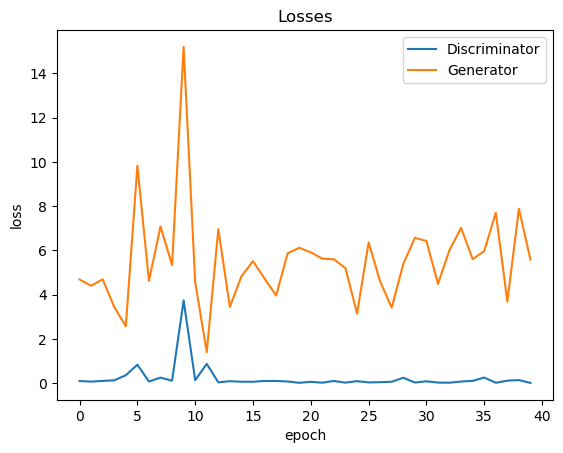

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

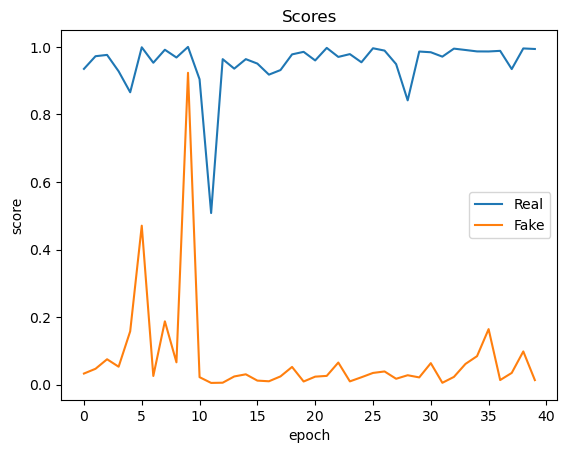

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');